In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Optional dependency: PyTorch for HMM implementation
try:
    import torch
except Exception as e:
    torch = None
    print("Warning: PyTorch not available. The HMM oracle requires PyTorch. Please install torch to train the HMM.")

In [15]:
# Load the corpus
with open('./corpus.txt', 'r') as f:
    corpus_words = [line.strip().lower() for line in f if line.strip()]

# Load the test set
with open('./test.txt', 'r') as f:
    test_words = [line.strip().lower() for line in f if line.strip()]

print(f"Corpus size: {len(corpus_words)} words")
print(f"Test set size: {len(test_words)} words")

Corpus size: 50000 words
Test set size: 2000 words


In [16]:
print(f"\nFirst 10 corpus words: {corpus_words[:10]}")
print(f"First 10 test words: {test_words[:10]}")


First 10 corpus words: ['suburbanize', 'asmack', 'hypotypic', 'promoderationist', 'consonantly', 'philatelically', 'cacomelia', 'thicklips', 'luciferase', 'cinematography']
First 10 test words: ['marmar', 'janet', 'dentistical', 'troveless', 'unnotify', 'gastrostenosis', 'preaffiliation', 'obpyriform', 'veratrinize', 'protection']


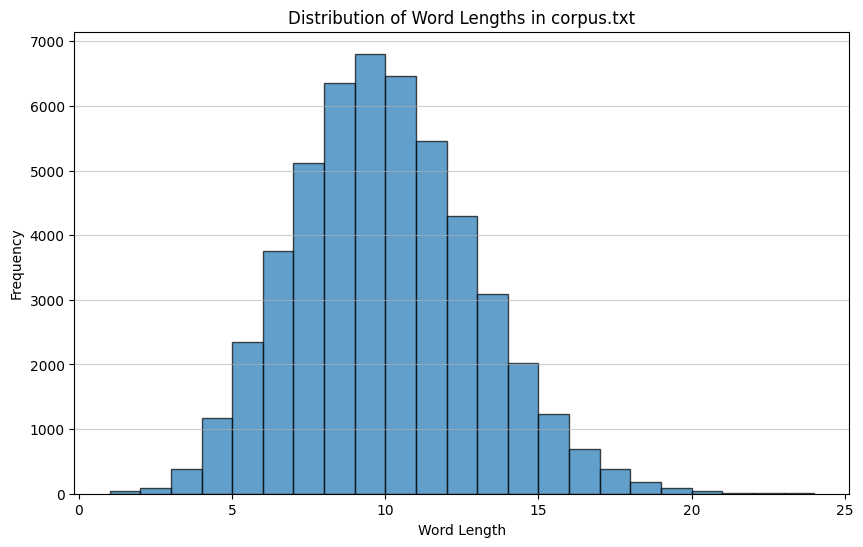

In [17]:
plt.figure(figsize=(10, 6))
corpus_lengths = [len(word) for word in corpus_words]
plt.hist(corpus_lengths, bins=range(1, max(corpus_lengths)+1), edgecolor='black', alpha=0.7) # Plot histogram of word lengths
plt.title('Distribution of Word Lengths in corpus.txt')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.6)
plt.show()

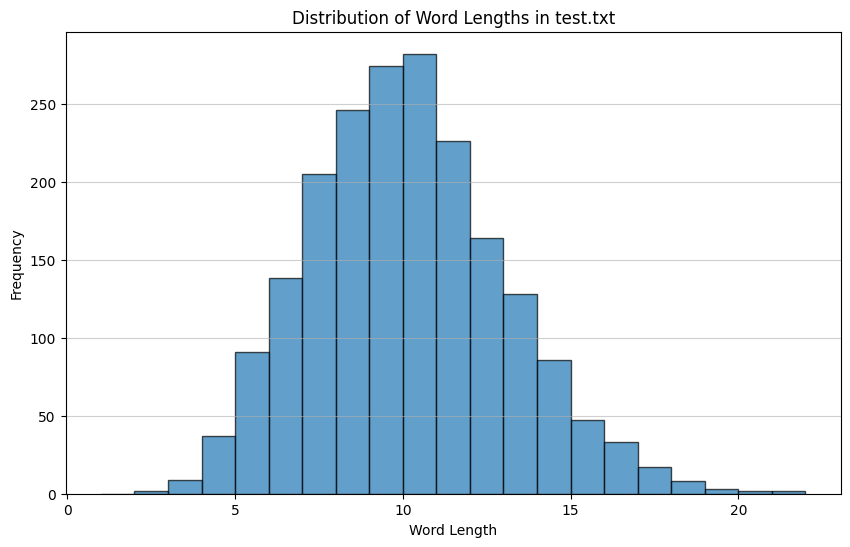

In [18]:
plt.figure(figsize=(10, 6))
test_lengths = [len(word) for word in test_words]
plt.hist(test_lengths, bins=range(1, max(test_lengths)+1), edgecolor='black', alpha=0.7) # Plot histogram of word lengths
plt.title('Distribution of Word Lengths in test.txt')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.6)
plt.show()

In [19]:
# statistics
print("corpus.txt")
print(f"Min word length: {min(corpus_lengths)}")
print(f"Max word length: {max(corpus_lengths)}")
print(f"Mean word length: {np.mean(corpus_lengths):.2f}")
print(f"Median word length: {np.median(corpus_lengths):.2f}")
print(f"Std word length: {np.std(corpus_lengths):.2f}")

corpus.txt
Min word length: 1
Max word length: 24
Mean word length: 9.50
Median word length: 9.00
Std word length: 2.96


In [20]:
print("test.txt")
print(f"Min word length: {min(test_lengths)}")
print(f"Max word length: {max(test_lengths)}")
print(f"Mean word length: {np.mean(test_lengths):.2f}")
print(f"Median word length: {np.median(test_lengths):.2f}")
print(f"Std word length: {np.std(test_lengths):.2f}")

test.txt
Min word length: 2
Max word length: 22
Mean word length: 9.64
Median word length: 9.00
Std word length: 2.92



Top 15 Most Frequent Letters:
Letter  Count  Percentage
     e  49224   10.365719
     a  42110    8.867634
     i  42068    8.858790
     o  35829    7.544965
     r  33619    7.079577
     n  33314    7.015349
     t  32191    6.778865
     s  29044    6.116162
     l  27406    5.771227
     c  21718    4.573433
     u  18397    3.874088
     p  16426    3.459030
     m  14670    3.089247
     d  14324    3.016385
     h  13643    2.872979


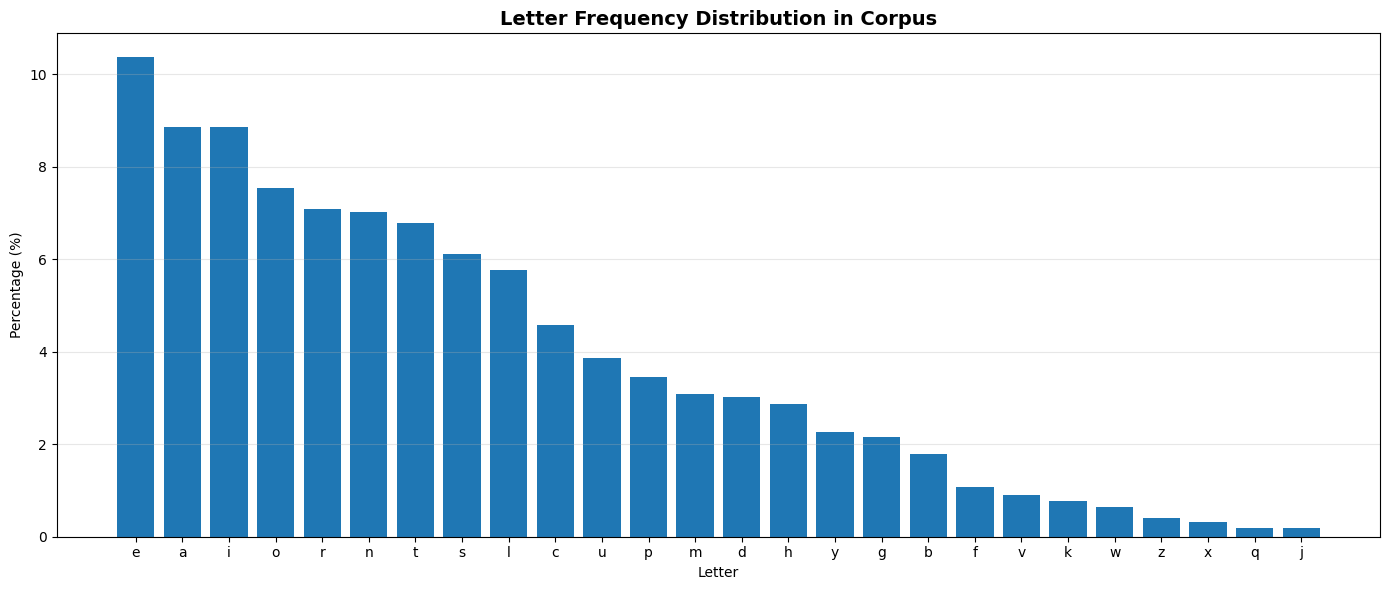

In [21]:
# letter frequency analysis

# Count letter frequencies
all_letters = ''.join(corpus_words)
letter_freq = Counter(all_letters)
total_letters = sum(letter_freq.values())

# Create DataFrame for better visualization
freq_df = pd.DataFrame([
    {'Letter': letter, 'Count': count, 'Percentage': (count/total_letters)*100}
    for letter, count in letter_freq.most_common()
])

print("\nTop 15 Most Frequent Letters:")
print(freq_df.head(15).to_string(index=False))

# Visualize
plt.figure(figsize=(14, 6))
plt.bar(freq_df['Letter'][:26], freq_df['Percentage'][:26])
plt.title('Letter Frequency Distribution in Corpus', fontsize=14, fontweight='bold')
plt.xlabel('Letter')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [22]:
# data cleaning

# Check for invalid characters
def validate_words(words, dataset_name):
    valid_chars = set('abcdefghijklmnopqrstuvwxyz')
    invalid_words = []

    for word in words:
        if not set(word).issubset(valid_chars):
            invalid_words.append(word)

    print(f"\n{dataset_name} Validation:")
    print(f"Total words: {len(words)}")
    print(f"Invalid words: {len(invalid_words)}")

    if invalid_words:
        print(f"Sample invalid words: {invalid_words[:5]}")

    return [word for word in words if set(word).issubset(valid_chars)]

In [23]:
# Clean datasets
corpus_words_clean = validate_words(corpus_words, "Corpus")
test_words_clean = validate_words(test_words, "Test Set")

# Check for duplicates
print(f"\nCorpus duplicates: {len(corpus_words_clean) - len(set(corpus_words_clean))}")
print(f"Test duplicates: {len(test_words_clean) - len(set(test_words_clean))}")

# Remove duplicates
corpus_words = list(set(corpus_words_clean))
test_words = list(set(test_words_clean))

print(f"\nBefore length filter: corpus={len(corpus_words)}, test={len(test_words)}")

# Filter to only words with length <= 7
corpus_words = [w for w in corpus_words if len(w) <= 7]
test_words = [w for w in test_words if len(w) <= 7]

print(f"After length filter (<=7): corpus={len(corpus_words)}, test={len(test_words)}")


Corpus Validation:
Total words: 50000
Invalid words: 21
Sample invalid words: ['au revoir', 'au revoir', 'au revoir', 'au revoir', 'au revoir']

Test Set Validation:
Total words: 2000
Invalid words: 0

Corpus duplicates: 582
Test duplicates: 0

Before length filter: corpus=49397, test=2000
After length filter (<=7): corpus=12388, test=482


# HMM Implementation
## Architecture (true HMM):
- Hidden states: latent phonotactic/structural states (you choose K; default K=10).
- Emissions: letters a–z.
- We train separate HMMs per word length via Baum–Welch (EM).

## Inference:
- Given a masked word (e.g., "_a__"), and the set of wrong guesses, we compute per-position letter distributions and an aggregated prior over the alphabet for the current blanks using forward–backward posteriors.

## Why this helps:
- The HMM captures contextual dependencies across positions and letters, providing a strong probabilistic prior that your RL agent can leverage to maximize success rate.

In [24]:
# True HMM (Discrete) with per-length manager
ALPHABET = [chr(c) for c in range(ord('a'), ord('z')+1)]
LETTER_TO_IDX = {ch:i for i,ch in enumerate(ALPHABET)}
IDX_TO_LETTER = {i:ch for ch,i in LETTER_TO_IDX.items()}

if torch is None:
    raise ImportError("PyTorch is required for the HMM oracle. Please install torch (CPU is fine).")


def _logsumexp(t, dim=-1):
    m, _ = torch.max(t, dim=dim, keepdim=True)
    return m + torch.log(torch.clamp(torch.sum(torch.exp(t - m), dim=dim, keepdim=True), min=1e-45))


class DiscreteHMM(torch.nn.Module):
    """
    Simple discrete HMM trained with Baum–Welch (EM) in log-space.
    - n_states: hidden state count
    - n_emissions: here 26 letters
    """
    def __init__(self, n_states, n_emissions, smooth=1e-2, device='cpu'):
        super().__init__()
        self.n_states = n_states
        self.n_emissions = n_emissions
        self.smooth = smooth
        self.device = torch.device(device)
        # log-space parameters
        self.log_pi = torch.log(torch.ones(n_states, device=self.device) / n_states)
        A = torch.rand(n_states, n_states, device=self.device)
        A = A / A.sum(dim=1, keepdim=True)
        self.log_A = torch.log(A)
        B = torch.rand(n_states, n_emissions, device=self.device)
        B = B / B.sum(dim=1, keepdim=True)
        self.log_B = torch.log(B)

    def _forward(self, obs_logB):
        T = obs_logB.shape[0]
        log_alpha = torch.empty(T, self.n_states, device=self.device)
        log_alpha[0] = self.log_pi + obs_logB[0]
        for t in range(1, T):
            prev = log_alpha[t-1].unsqueeze(1) + self.log_A  # [S,S]
            log_alpha[t] = _logsumexp(prev, dim=0).squeeze(0) + obs_logB[t]
        ll = _logsumexp(log_alpha[-1], dim=0).squeeze(0)
        return log_alpha, ll

    def _backward(self, obs_logB):
        T = obs_logB.shape[0]
        log_beta = torch.empty(T, self.n_states, device=self.device)
        log_beta[-1] = torch.zeros(self.n_states, device=self.device)
        for t in range(T-2, -1, -1):
            tmp = self.log_A + (obs_logB[t+1] + log_beta[t+1]).unsqueeze(0)  # [S,S]
            log_beta[t] = _logsumexp(tmp, dim=1).squeeze(1)
        return log_beta

    def _obs_logB_from_sequence(self, seq, mask_allowed=None):
        # seq: list of int or -1 for unknown; mask_allowed[t] optional boolean mask over emissions at t
        T = len(seq)
        obs_logB = torch.empty(T, self.n_states, device=self.device)
        for t, sym in enumerate(seq):
            if sym >= 0:
                obs_logB[t] = self.log_B[:, sym]
            else:
                # Unknown emission: integrate over allowed emissions => logsumexp over emissions per state
                if mask_allowed is not None and mask_allowed[t] is not None:
                    mask = mask_allowed[t].to(self.device)
                else:
                    mask = torch.ones(self.n_emissions, device=self.device, dtype=torch.bool)
                logB = self.log_B.clone()
                logB[:, ~mask] = -1e9  # disallow
                obs_logB[t] = _logsumexp(logB, dim=1).squeeze(1)
        return obs_logB

    def fit(self, sequences, epochs=10):
        for ep in range(epochs):
            sum_pi = torch.full((self.n_states,), self.smooth, device=self.device)
            sum_A_num = torch.full((self.n_states, self.n_states), self.smooth, device=self.device)
            sum_A_den = torch.full((self.n_states,), self.smooth, device=self.device)
            sum_B_num = torch.full((self.n_states, self.n_emissions), self.smooth, device=self.device)
            sum_B_den = torch.full((self.n_states,), self.smooth, device=self.device)
            total_ll = 0.0
            for seq in sequences:
                seq = torch.tensor(seq, device=self.device, dtype=torch.long)
                obs_logB = self.log_B[:, seq].T  # [T,S]
                log_alpha, ll = self._forward(obs_logB)
                log_beta = self._backward(obs_logB)
                total_ll += float(ll.item())
                log_gamma = log_alpha + log_beta
                log_gamma = log_gamma - _logsumexp(log_gamma, dim=1)
                gamma = torch.exp(log_gamma)  # [T,S]
                Tlen = seq.shape[0]
                for t in range(Tlen-1):
                    tmp = (
                        log_alpha[t].unsqueeze(1)
                        + self.log_A
                        + self.log_B[:, seq[t+1]].unsqueeze(0)
                        + log_beta[t+1].unsqueeze(0)
                    )
                    tmp = tmp - _logsumexp(tmp.view(-1), dim=0)
                    xi = torch.exp(tmp)
                    sum_A_num += xi
                    sum_A_den += gamma[t]
                sum_pi += gamma[0]
                # emissions
                sum_B_num.index_add_(1, seq, gamma.T)
                sum_B_den += gamma.sum(dim=0)
            # normalize
            self.log_pi = torch.log(sum_pi / sum_pi.sum())
            self.log_A = torch.log(sum_A_num / sum_A_num.sum(dim=1, keepdim=True))
            self.log_B = torch.log(sum_B_num / sum_B_num.sum(dim=1, keepdim=True))
            print(f"HMM-EM epoch {ep+1}/{epochs} | mean LL ~ {total_ll / max(1, len(sequences)):.4f}")

    @torch.no_grad()
    def posterior_letter_probs(self, pattern, guessed_wrong=set()):
        """Return per-position letter probs [T, M] and aggregated blank prior [M].
        pattern: string like "_a__"; guessed_wrong: letters known not in word.
        """
        T = len(pattern)
        seq = []
        mask_allowed = []
        wrong_set = set(guessed_wrong)
        for ch in pattern:
            if ch == '_' or ch == '*':
                seq.append(-1)
                m = torch.ones(self.n_emissions, dtype=torch.bool)
                for w in wrong_set:
                    m[LETTER_TO_IDX[w]] = False
                mask_allowed.append(m)
            else:
                seq.append(LETTER_TO_IDX[ch])
                mask_allowed.append(None)
        obs_logB = self._obs_logB_from_sequence(seq, mask_allowed)
        log_alpha, _ = self._forward(obs_logB)
        log_beta = self._backward(obs_logB)
        log_gamma = log_alpha + log_beta
        log_gamma = log_gamma - _logsumexp(log_gamma, dim=1)
        gamma = torch.exp(log_gamma)  # [T,S]
        B = torch.exp(self.log_B)
        pos_probs = torch.matmul(gamma, B)  # [T,M]
        # handle known positions and masks
        for t, (sym, m) in enumerate(zip(seq, mask_allowed)):
            if sym >= 0:
                vec = torch.zeros(self.n_emissions, device=self.device)
                vec[sym] = 1.0
                pos_probs[t] = vec
            else:
                if m is not None:
                    pos_probs[t, ~m.to(self.device)] = 0.0
                s = pos_probs[t].sum()
                if s > 0:
                    pos_probs[t] /= s
        agg = torch.zeros(self.n_emissions, device=self.device)
        for t, sym in enumerate(seq):
            if sym < 0:
                agg += pos_probs[t]
        if agg.sum() > 0:
            agg = agg / agg.sum()
        return pos_probs, agg


class HMMManager:
    def __init__(self, n_states=10, device='cpu'):
        self.n_states = n_states
        self.device = device
        self.models = {}

    def train_per_length(self, words_by_len, epochs=10, smooth=1e-2):
        for L, words in sorted(words_by_len.items()):
            if L < 1:
                continue
            seqs = [[LETTER_TO_IDX[ch] for ch in w] for w in words]
            hmm = DiscreteHMM(self.n_states, len(ALPHABET), smooth=smooth, device=self.device)
            print(f"Training HMM for length {L} on {len(seqs)} words")
            hmm.fit(seqs, epochs=epochs)
            self.models[L] = hmm

    @torch.no_grad()
    def letter_posteriors(self, pattern, guessed_wrong=set()):
        L = len(pattern)
        if L in self.models:
            return self.models[L].posterior_letter_probs(pattern, guessed_wrong)
        # uniform fallback for unseen lengths
        M = len(ALPHABET)
        pos = torch.ones(L, M) / M
        agg = pos.mean(dim=0)
        return pos, agg

In [25]:
# Initialize and train per-length HMMs (true HMM oracle)
assert torch is not None, "PyTorch is required for the HMM oracle. Please install torch."

# Group words by length
words_by_len = defaultdict(list)
for w in corpus_words:
    words_by_len[len(w)].append(w)

hmm_manager = HMMManager(n_states=10, device='cpu')
hmm_manager.train_per_length(words_by_len, epochs=10)

# Quick oracle tests using posterior_letter_probs / letter_posteriors
print("\n" + "="*70)
print("TESTING TRUE HMM ORACLE (per-length models)")
print("="*70)

test_cases = [
    ("_pp__", {'p'}, "apple"),
    ("_e___", {'e'}, "hello"),
    ("____", set(), "test"),
]

for masked, guessed, actual_word in test_cases:
    # Derive wrong guesses as those guessed but not in the masked string
    guessed_wrong = {g for g in guessed if g not in masked}
    pos_probs, agg = hmm_manager.letter_posteriors(masked, guessed_wrong)
    agg_np = agg.detach().cpu().numpy()
    top_idx = agg_np.argsort()[::-1][:5]
    top5 = [(IDX_TO_LETTER[i], float(agg_np[i])) for i in top_idx]

    needed_letters = set(actual_word) - set([c for c in masked if c != '_']) - guessed
    overlap = set([l for l, _ in top5]) & needed_letters

    print(f"\nWord: {actual_word:8s} | Masked: {masked:8s} | Guessed: {sorted(guessed)}")
    print(f"  Top 5 prior: {[f'{l}({p:.3f})' for l,p in top5]}")
    print(f"  Need: {sorted(needed_letters)} | Found in top 5: {sorted(overlap)}")

print("\nHMM oracle ready.")

Training HMM for length 1 on 23 words
HMM-EM epoch 1/10 | mean LL ~ -3.2399
HMM-EM epoch 2/10 | mean LL ~ -3.1473
HMM-EM epoch 3/10 | mean LL ~ -3.1473
HMM-EM epoch 4/10 | mean LL ~ -3.1473
HMM-EM epoch 5/10 | mean LL ~ -3.1473
HMM-EM epoch 6/10 | mean LL ~ -3.1473
HMM-EM epoch 7/10 | mean LL ~ -3.1473
HMM-EM epoch 8/10 | mean LL ~ -3.1473
HMM-EM epoch 9/10 | mean LL ~ -3.1473
HMM-EM epoch 10/10 | mean LL ~ -3.1473
Training HMM for length 2 on 70 words
HMM-EM epoch 1/10 | mean LL ~ -6.5251
HMM-EM epoch 2/10 | mean LL ~ -6.2874
HMM-EM epoch 3/10 | mean LL ~ -6.2761
HMM-EM epoch 4/10 | mean LL ~ -6.2596
HMM-EM epoch 1/10 | mean LL ~ -6.5251
HMM-EM epoch 2/10 | mean LL ~ -6.2874
HMM-EM epoch 3/10 | mean LL ~ -6.2761
HMM-EM epoch 4/10 | mean LL ~ -6.2596
HMM-EM epoch 5/10 | mean LL ~ -6.2304
HMM-EM epoch 6/10 | mean LL ~ -6.1796
HMM-EM epoch 5/10 | mean LL ~ -6.2304
HMM-EM epoch 6/10 | mean LL ~ -6.1796
HMM-EM epoch 7/10 | mean LL ~ -6.1049
HMM-EM epoch 8/10 | mean LL ~ -6.0184
HMM-EM epoc

In [26]:
# Quick oracle smoke tests (replacing old MultiLevelHMM tests)
test_cases = [
    ("_pp__", {'p'}, "apple"),
    ("q_", set(), "qu"),
    ("th_", set(), "the"),
]

for masked, guessed, actual_word in test_cases:
    guessed_wrong = {g for g in guessed if g not in masked}
    _, agg = hmm_manager.letter_posteriors(masked, guessed_wrong)
    agg_np = agg.detach().cpu().numpy()
    top3_idx = agg_np.argsort()[::-1][:3]
    top3 = [(IDX_TO_LETTER[i], float(agg_np[i])) for i in top3_idx]
    print(f"{actual_word}: {[f'{l}({p:.3f})' for l, p in top3]}")

apple: ['a(0.111)', 'e(0.086)', 's(0.065)']
qu: ['n(0.092)', 'q(0.084)', 'd(0.071)']
the: ['a(0.144)', 'o(0.096)', 'e(0.094)']


In [27]:
# Oracle check with a few masks
more_tests = [
    ("_a_", {'a'}, "cat"),
    ("__e", set(), "the"),
    ("___ing", set(), "testing"),
]
for masked, guessed, actual_word in more_tests:
    guessed_wrong = {g for g in guessed if g not in masked}
    _, agg = hmm_manager.letter_posteriors(masked, guessed_wrong)
    agg_np = agg.detach().cpu().numpy()
    top3_idx = agg_np.argsort()[::-1][:3]
    top3 = [(IDX_TO_LETTER[i], float(agg_np[i])) for i in top3_idx]
    print(f"{actual_word}: {[f'{l}({p:.3f})' for l, p in top3]}")

cat: ['m(0.063)', 'r(0.060)', 'a(0.059)']
the: ['a(0.103)', 'o(0.082)', 'e(0.071)']
testing: ['e(0.092)', 'a(0.089)', 'r(0.073)']


# RL Agent

In [28]:
class HangmanGame:
    def __init__(self, word, max_wrong=6):
        self.word = word.lower()
        self.max_wrong = max_wrong
        self.reset()

    def reset(self):
        """
        Reset the game state.
        """
        self.guessed_letters = set()
        self.wrong_guesses = 0
        self.masked_word = '_' * len(self.word)
        self.game_over = False
        self.won = False
        return self._get_state()

    def step(self, letter):
        """
        Make a guess and return (state, reward, done, info).
        """
        letter = letter.lower()

        # Repeated guess
        if letter in self.guessed_letters:
            return self._get_state(), -10, self.game_over, {'repeated': True}

        self.guessed_letters.add(letter)

        # Check if letter in word
        if letter in self.word:
            # Update masked word
            new_masked = ''
            for i, char in enumerate(self.word):
                if char in self.guessed_letters:
                    new_masked += char
                else:
                    new_masked += '_'

            self.masked_word = new_masked

            # Check win condition
            if '_' not in self.masked_word:
                self.game_over = True
                self.won = True
                return self._get_state(), 100, True, {'won': True}

            # Correct guess reward
            return self._get_state(), 10, False, {'correct': True}

        else:
            # Wrong guess
            self.wrong_guesses += 1

            # Check lose condition
            if self.wrong_guesses >= self.max_wrong:
                self.game_over = True
                return self._get_state(), -50, True, {'lost': True}

            # Wrong guess penalty
            return self._get_state(), -5, False, {'wrong': True}

    def _get_state(self):
        """
        Return current game state.
        """
        return {
            'masked_word': self.masked_word,
            'guessed_letters': self.guessed_letters.copy(),
            'wrong_guesses': self.wrong_guesses,
            'lives_left': self.max_wrong - self.wrong_guesses
        }

    def get_available_actions(self):
        """
        Return letters that haven't been guessed yet.
        """
        all_letters = set('abcdefghijklmnopqrstuvwxyz')
        return all_letters - self.guessed_letters

print("Hangman Game Environment created!")

Hangman Game Environment created!


In [29]:
# RL agent with Q-learning powered by HMM oracle priors

class HangmanRLAgent:
    def __init__(self, hmm_manager, alpha=0.05, gamma=0.95, epsilon=1.0,
                 epsilon_decay=0.9995, epsilon_min=0.05, prior_weight=10.0):
        self.hmm_manager = hmm_manager
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.prior_weight = prior_weight  # strength of HMM prior in exploitation
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.stats = {
            'wins': 0, 'losses': 0, 'total_games': 0,
            'total_wrong_guesses': 0, 'total_repeated_guesses': 0
        }

    def _get_state_key(self, state):
        return (state['masked_word'], frozenset(state['guessed_letters']), state['wrong_guesses'])

    def _hmm_prior(self, masked_word, guessed_letters):
        # derive wrong guesses as guessed letters not present in the masked word
        guessed_wrong = {g for g in guessed_letters if g not in masked_word}
        _, agg = self.hmm_manager.letter_posteriors(masked_word, guessed_wrong)
        prior = agg.detach().cpu().numpy()
        return {IDX_TO_LETTER[i]: float(prior[i]) for i in range(len(ALPHABET))}

    def choose_action(self, state, game, training=True):
        """Choose a valid action; exploration samples from HMM prior over available actions.
        Exploitation scores each available letter as q + prior_weight * hmm_prob.
        """
        available_actions = game.get_available_actions()
        if not available_actions:
            print(f"WARNING: No available actions! State: {state}")
            return None

        hmm_probs = self._hmm_prior(state['masked_word'], state['guessed_letters'])

        # Exploration
        if training and np.random.random() < self.epsilon:
            # sample proportional to HMM prior but restricted to available actions
            avail_prior = {a: hmm_probs.get(a, 0.0) for a in available_actions}
            s = sum(avail_prior.values())
            if s > 0:
                letters = list(avail_prior.keys())
                probs = np.array([avail_prior[l] for l in letters], dtype=np.float64)
                probs = probs / probs.sum()
                return np.random.choice(letters, p=probs)
            return np.random.choice(list(available_actions))

        # Exploitation: q + prior_weight * hmm_prob
        state_key = self._get_state_key(state)
        action_scores = {}
        for a in available_actions:
            qv = self.q_table[state_key][a]
            pv = hmm_probs.get(a, 0.0)
            action_scores[a] = qv + self.prior_weight * pv
        if not action_scores:
            return np.random.choice(list(available_actions))
        return max(action_scores, key=action_scores.get)

    def update_q_value(self, state, action, reward, next_state, done):
        state_key = self._get_state_key(state)
        next_state_key = self._get_state_key(next_state)
        current_q = self.q_table[state_key][action]
        if done:
            max_next_q = 0.0
        else:
            next_q_values = self.q_table[next_state_key]
            max_next_q = max(next_q_values.values()) if next_q_values else 0.0
        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[state_key][action] = new_q

    def train_episode(self, word):
        game = HangmanGame(word)
        state = game.reset()
        total_reward = 0
        steps = 0
        max_steps = 50
        while not game.game_over and steps < max_steps:
            action = self.choose_action(state, game, training=True)
            if action is None:
                break
            # Safety: ensure action not repeated (environment already penalizes repeats)
            next_state, reward, done, info = game.step(action)
            self.update_q_value(state, action, reward, next_state, done)
            total_reward += reward
            state = next_state
            steps += 1
            if 'repeated' in info:
                self.stats['total_repeated_guesses'] += 1
            elif 'wrong' in info:
                self.stats['total_wrong_guesses'] += 1
        self.stats['total_games'] += 1
        if game.won:
            self.stats['wins'] += 1
        else:
            self.stats['losses'] += 1
        return total_reward

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [30]:
# Initialize agent (uses true HMM oracle)
agent = HangmanRLAgent(
    hmm_manager=hmm_manager,
    alpha=0.05,
    gamma=0.95,
    epsilon=1.0,
    epsilon_decay=0.9995,
    epsilon_min=0.05,
    prior_weight=15.0  # stronger reliance on HMM to prioritize success rate
)

# Training parameters
n_episodes = 10000
eval_frequency = 1000

# Training tracking
episode_rewards = []
win_rates = []
avg_wrong_guesses = []
epsilon_history = []

print("Starting Training...")
print(f"Episodes: {n_episodes}")
print(f"Corpus size: {len(corpus_words)}")
print("=" * 60)

for episode in tqdm(range(n_episodes)):
    # Sample random word from corpus
    word = np.random.choice(corpus_words)

    # Train episode
    reward = agent.train_episode(word)
    episode_rewards.append(reward)

    # Decay epsilon
    agent.decay_epsilon()
    epsilon_history.append(agent.epsilon)

    # Periodic evaluation
    if (episode + 1) % eval_frequency == 0:
        win_rate = agent.stats['wins'] / max(1, agent.stats['total_games'])
        avg_wrong = agent.stats['total_wrong_guesses'] / max(1, agent.stats['total_games'])

        win_rates.append(win_rate)
        avg_wrong_guesses.append(avg_wrong)

        print(f"\nEpisode {episode + 1}/{n_episodes}")
        print(f"Win Rate: {win_rate:.2%}")
        print(f"Avg Wrong Guesses: {avg_wrong:.2f}")
        print(f"Epsilon: {agent.epsilon:.4f}")
        print(f"Avg Reward (last 100): {np.mean(episode_rewards[-100:]):.2f}")
        print("=" * 60)

        # Reset stats for next evaluation period
        agent.stats = {
            'wins': 0,
            'losses': 0,
            'total_games': 0,
            'total_wrong_guesses': 0,
            'total_repeated_guesses': 0
        }

print("\nTraining Complete!")

Starting Training...
Episodes: 10000
Corpus size: 12388


 10%|█         | 1005/10000 [00:23<03:14, 46.13it/s]


Episode 1000/10000
Win Rate: 5.10%
Avg Wrong Guesses: 4.93
Epsilon: 0.6065
Avg Reward (last 100): -32.90


 20%|██        | 2004/10000 [00:44<02:51, 46.69it/s]


Episode 2000/10000
Win Rate: 6.70%
Avg Wrong Guesses: 4.93
Epsilon: 0.3678
Avg Reward (last 100): -29.45


 30%|███       | 3003/10000 [01:09<02:36, 44.74it/s]


Episode 3000/10000
Win Rate: 10.80%
Avg Wrong Guesses: 4.86
Epsilon: 0.2230
Avg Reward (last 100): -25.25


 40%|████      | 4009/10000 [01:32<02:04, 48.25it/s]


Episode 4000/10000
Win Rate: 10.50%
Avg Wrong Guesses: 4.87
Epsilon: 0.1353
Avg Reward (last 100): -14.90


 50%|█████     | 5008/10000 [01:56<01:54, 43.64it/s]


Episode 5000/10000
Win Rate: 11.60%
Avg Wrong Guesses: 4.87
Epsilon: 0.0820
Avg Reward (last 100): -22.75


 60%|██████    | 6007/10000 [02:19<01:27, 45.85it/s]


Episode 6000/10000
Win Rate: 10.60%
Avg Wrong Guesses: 4.88
Epsilon: 0.0500
Avg Reward (last 100): -26.30


 70%|███████   | 7005/10000 [02:46<01:44, 28.76it/s]


Episode 7000/10000
Win Rate: 11.10%
Avg Wrong Guesses: 4.87
Epsilon: 0.0500
Avg Reward (last 100): -25.20


 80%|████████  | 8005/10000 [03:15<00:46, 42.48it/s]


Episode 8000/10000
Win Rate: 12.00%
Avg Wrong Guesses: 4.84
Epsilon: 0.0500
Avg Reward (last 100): -28.75


 90%|█████████ | 9007/10000 [03:38<00:21, 45.79it/s]


Episode 9000/10000
Win Rate: 11.60%
Avg Wrong Guesses: 4.88
Epsilon: 0.0500
Avg Reward (last 100): -29.30


100%|██████████| 10000/10000 [04:01<00:00, 41.38it/s]


Episode 10000/10000
Win Rate: 12.30%
Avg Wrong Guesses: 4.86
Epsilon: 0.0500
Avg Reward (last 100): -26.00

Training Complete!


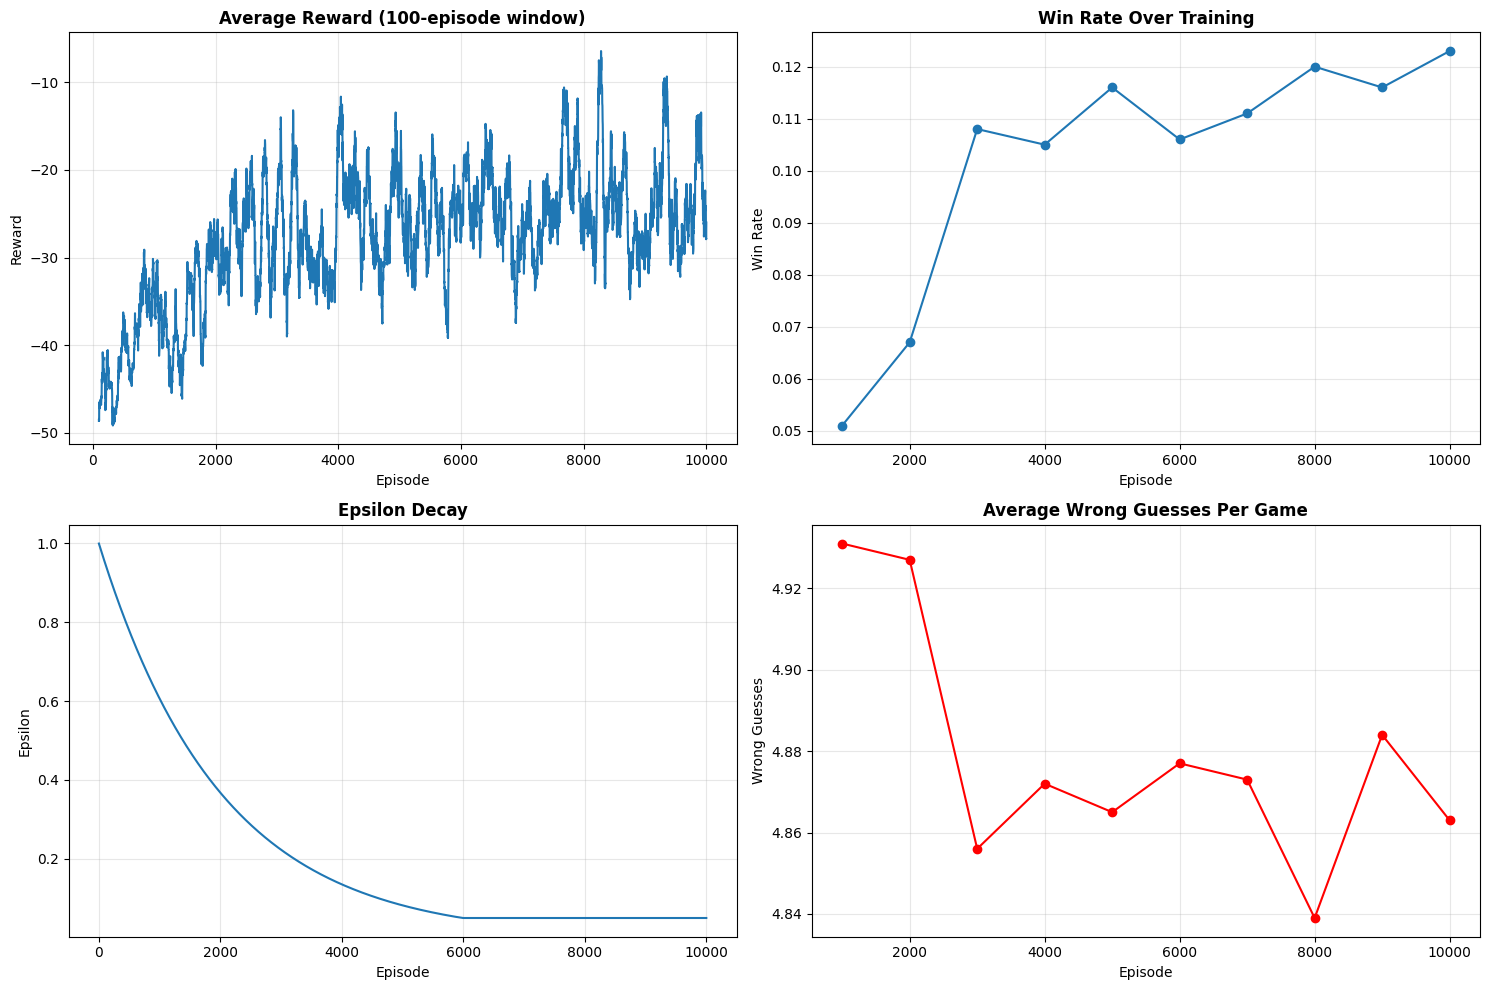

Training plots saved as 'training_progress.png'


In [31]:
# Plot training metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Rewards
window = 100
rolling_rewards = pd.Series(episode_rewards).rolling(window).mean()
axes[0, 0].plot(rolling_rewards)
axes[0, 0].set_title('Average Reward (100-episode window)', fontweight='bold')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].grid(alpha=0.3)

# Win rate
eval_episodes = np.arange(eval_frequency, n_episodes + 1, eval_frequency)
axes[0, 1].plot(eval_episodes, win_rates, marker='o')
axes[0, 1].set_title('Win Rate Over Training', fontweight='bold')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Win Rate')
axes[0, 1].grid(alpha=0.3)

# Epsilon decay
axes[1, 0].plot(epsilon_history)
axes[1, 0].set_title('Epsilon Decay', fontweight='bold')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Epsilon')
axes[1, 0].grid(alpha=0.3)

# Average wrong guesses
axes[1, 1].plot(eval_episodes, avg_wrong_guesses, marker='o', color='red')
axes[1, 1].set_title('Average Wrong Guesses Per Game', fontweight='bold')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Wrong Guesses')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_progress.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training plots saved as 'training_progress.png'")

# Testing

In [32]:
def evaluate_agent(agent, test_words, max_games=None, verbose=True):
    """
    Evaluate agent on test set.
    """
    if max_games:
        test_words = test_words[:max_games]

    results = {
        'wins': 0,
        'losses': 0,
        'total_wrong_guesses': 0,
        'total_repeated_guesses': 0,
        'game_details': []
    }

    for word in tqdm(test_words, desc="Evaluating"):
        game = HangmanGame(word)
        state = game.reset()

        wrong_guesses = 0
        repeated_guesses = 0

        while not game.game_over:
            action = agent.choose_action(state, game, training=False)

            if action is None:
                break

            next_state, reward, done, info = game.step(action)

            if 'repeated' in info:
                repeated_guesses += 1
            elif 'wrong' in info:
                wrong_guesses += 1

            state = next_state

        # Record results
        if game.won:
            results['wins'] += 1
        else:
            results['losses'] += 1

        results['total_wrong_guesses'] += wrong_guesses
        results['total_repeated_guesses'] += repeated_guesses

        results['game_details'].append({
            'word': word,
            'won': game.won,
            'wrong_guesses': wrong_guesses,
            'repeated_guesses': repeated_guesses
        })

    # Calculate final score
    total_games = len(test_words)
    success_rate = results['wins'] / total_games

    final_score = (
        (success_rate * 2000) -
        (results['total_wrong_guesses'] * 5) -
        (results['total_repeated_guesses'] * 2)
    )

    results['total_games'] = total_games
    results['success_rate'] = success_rate
    results['final_score'] = final_score
    results['avg_wrong_guesses'] = results['total_wrong_guesses'] / total_games
    results['avg_repeated_guesses'] = results['total_repeated_guesses'] / total_games

    if verbose:
        print("\n" + "=" * 60)
        print("EVALUATION RESULTS")
        print("=" * 60)
        print(f"Total Games: {total_games}")
        print(f"Wins: {results['wins']}")
        print(f"Losses: {results['losses']}")
        print(f"Success Rate: {success_rate:.2%}")
        print(f"Total Wrong Guesses: {results['total_wrong_guesses']}")
        print(f"Total Repeated Guesses: {results['total_repeated_guesses']}")
        print(f"Avg Wrong Guesses/Game: {results['avg_wrong_guesses']:.2f}")
        print(f"Avg Repeated Guesses/Game: {results['avg_repeated_guesses']:.2f}")
        print("\n" + "=" * 60)
        print(f"FINAL SCORE: {final_score:.2f}")
        print("=" * 60)

    return results

print("Evaluation function ready!")

Evaluation function ready!


In [33]:
# Evaluate on full test set
print(f"Evaluating on {len(test_words)} test words...\n")
test_results = evaluate_agent(agent, test_words)

Evaluating on 482 test words...



Evaluating: 100%|██████████| 482/482 [00:09<00:00, 53.20it/s]


EVALUATION RESULTS
Total Games: 482
Wins: 54
Losses: 428
Success Rate: 11.20%
Total Wrong Guesses: 2351
Total Repeated Guesses: 0
Avg Wrong Guesses/Game: 4.88
Avg Repeated Guesses/Game: 0.00

FINAL SCORE: -11530.93



Performance by Word Length:
             Total Games  Wins  Win Rate  Avg Wrong  Avg Repeated
word_length                                                      
2                      2     0     0.000      5.000           0.0
3                      9     1     0.111      5.000           0.0
4                     37     3     0.081      4.865           0.0
5                     91     9     0.099      4.923           0.0
6                    138    14     0.101      4.884           0.0
7                    205    27     0.132      4.849           0.0


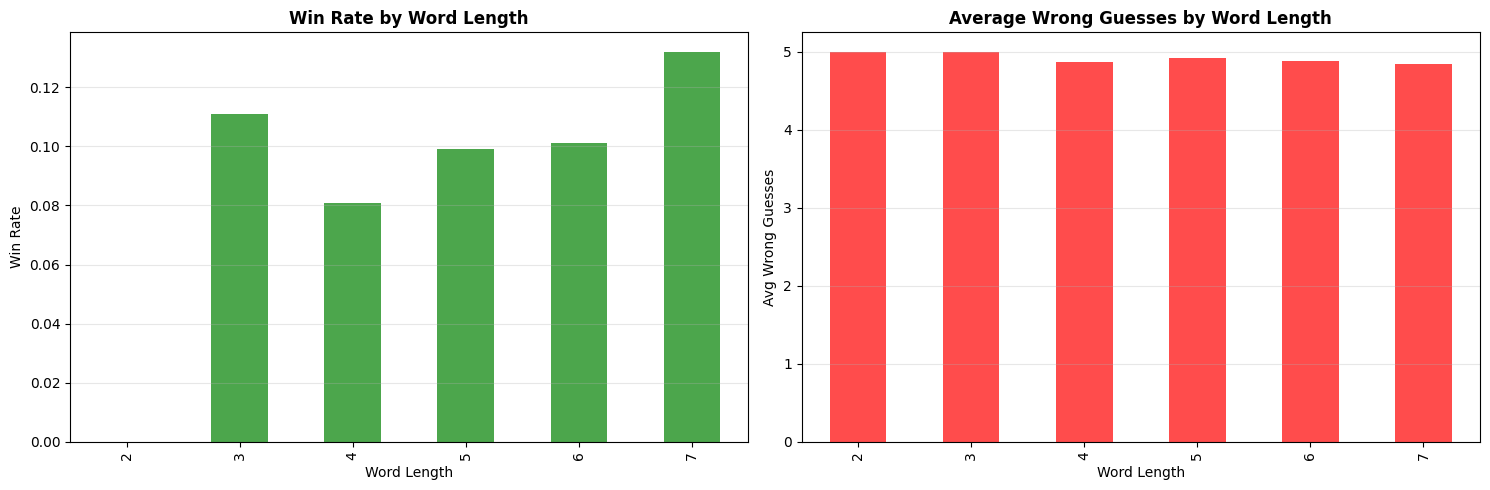

In [34]:
# Analyze performance by word length
results_df = pd.DataFrame(test_results['game_details'])
results_df['word_length'] = results_df['word'].apply(len)

# Group by length
length_analysis = results_df.groupby('word_length').agg({
    'won': ['count', 'sum', 'mean'],
    'wrong_guesses': 'mean',
    'repeated_guesses': 'mean'
}).round(3)

length_analysis.columns = ['Total Games', 'Wins', 'Win Rate',
                           'Avg Wrong', 'Avg Repeated']

print("\nPerformance by Word Length:")
print(length_analysis)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Win rate by length
length_analysis['Win Rate'].plot(kind='bar', ax=axes[0], color='green', alpha=0.7)
axes[0].set_title('Win Rate by Word Length', fontweight='bold')
axes[0].set_xlabel('Word Length')
axes[0].set_ylabel('Win Rate')
axes[0].grid(alpha=0.3, axis='y')

# Average wrong guesses by length
length_analysis['Avg Wrong'].plot(kind='bar', ax=axes[1], color='red', alpha=0.7)
axes[1].set_title('Average Wrong Guesses by Word Length', fontweight='bold')
axes[1].set_xlabel('Word Length')
axes[1].set_ylabel('Avg Wrong Guesses')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('word_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [35]:
# Find words the agent struggled with
lost_words = results_df[results_df['won'] == False].sort_values(
    'wrong_guesses', ascending=False
)

print("\nTop 20 Most Difficult Words (Lost Games):")
print(lost_words[['word', 'word_length', 'wrong_guesses', 'repeated_guesses']].head(20))

# Words with repeated guesses
repeated = results_df[results_df['repeated_guesses'] > 0].sort_values(
    'repeated_guesses', ascending=False
)

print("\nTop 10 Words with Most Repeated Guesses:")
print(repeated[['word', 'won', 'wrong_guesses', 'repeated_guesses']].head(10))


Top 20 Most Difficult Words (Lost Games):
        word  word_length  wrong_guesses  repeated_guesses
481    cumbu            5              5                 0
0      breme            5              5                 0
1        gup            3              5                 0
2    synodus            7              5                 0
3      ismal            5              5                 0
4    zoeform            7              5                 0
5     gelose            6              5                 0
6      flong            5              5                 0
7    drivage            7              5                 0
8     ugroid            6              5                 0
9     pronpl            6              5                 0
10   upcrowd            7              5                 0
439  pewmate            7              5                 0
440  popshop            7              5                 0
441   cocash            6              5                 0
442  typeset 

In [37]:
print("\n" + "="*70)
print("DIAGNOSTIC ANALYSIS")
print("="*70)

# Test HMM quality on ACTUAL corpus words
import random
random.seed(42)

correct_first_guess = 0
correct_in_top3 = 0
total_tests = 100

test_sample = random.sample(corpus_words, min(100, len(corpus_words)))

for test_word in test_sample:
    # Simulate mid-game: reveal 2 letters
    if len(test_word) < 3:
        continue

    reveal_positions = random.sample(range(len(test_word)), min(2, len(test_word)))
    masked = ''.join([test_word[i] if i in reveal_positions else '_'
                      for i in range(len(test_word))])
    guessed = set(test_word[i] for i in reveal_positions)

    # Get HMM prediction via hmm_manager
    guessed_wrong = {g for g in guessed if g not in masked}
    _, agg = hmm_manager.letter_posteriors(masked, guessed_wrong)
    agg_np = agg.detach().cpu().numpy()
    
    # Convert to dict for compatibility
    probs = {IDX_TO_LETTER[i]: float(agg_np[i]) for i in range(len(ALPHABET))}
    
    if not probs:
        continue

    top_predictions = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:3]

    # What we actually need
    remaining_letters = set(test_word) - guessed

    if top_predictions and top_predictions[0][0] in remaining_letters:
        correct_first_guess += 1

    if any(pred[0] in remaining_letters for pred in top_predictions):
        correct_in_top3 += 1

print(f"\nHMM Prediction Accuracy (on {total_tests} corpus words):")
print(f"  First guess correct: {correct_first_guess/total_tests:.1%}")
print(f"  Correct in top 3: {correct_in_top3/total_tests:.1%}")

print(f"\n{'='*70}")

# Analyze by game stage
print("\nPerformance by Game Stage:")

for stage, reveal_ratio in [("Early (1 letter)", 0.15),
                             ("Mid (40% letters)", 0.40),
                             ("Late (70% letters)", 0.70)]:
    correct = 0
    total = 0

    for test_word in test_sample[:50]:
        if len(test_word) < 3:
            continue

        reveal_count = max(1, int(len(test_word) * reveal_ratio))
        reveal_positions = random.sample(range(len(test_word)), reveal_count)
        masked = ''.join([test_word[i] if i in reveal_positions else '_'
                          for i in range(len(test_word))])
        guessed = set(test_word[i] for i in reveal_positions)

        # Get HMM prediction via hmm_manager
        guessed_wrong = {g for g in guessed if g not in masked}
        _, agg = hmm_manager.letter_posteriors(masked, guessed_wrong)
        agg_np = agg.detach().cpu().numpy()
        probs = {IDX_TO_LETTER[i]: float(agg_np[i]) for i in range(len(ALPHABET))}
        
        if not probs:
            continue

        top_pred = max(probs, key=probs.get)
        remaining = set(test_word) - guessed

        if top_pred in remaining:
            correct += 1
        total += 1

    if total > 0:
        print(f"  {stage}: {correct/total:.1%}")

print(f"\n{'='*70}")

# Check if specific patterns work
print("\nPattern Recognition Tests:")

patterns = [
    ("q_", "qu", "u"),
    ("_q", "aq", "a"),
    ("th_", "the", "e"),
    ("__e", "the", "th"),
    ("___ing", "testing", "test"),
]

for masked, actual, expected_letters in patterns:
    guessed = set(c for c in masked if c != '_')
    guessed_wrong = {g for g in guessed if g not in masked}
    _, agg = hmm_manager.letter_posteriors(masked, guessed_wrong)
    agg_np = agg.detach().cpu().numpy()
    probs = {IDX_TO_LETTER[i]: float(agg_np[i]) for i in range(len(ALPHABET))}

    if probs:
        top_3 = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:3]
        top_letters = [l for l, p in top_3]

        found = any(e in top_letters for e in expected_letters)
        status = "✓" if found else "✗"

        print(f"  {status} {masked:10s} → Top 3: {top_letters} (want: {list(expected_letters)})")

print("="*70)


DIAGNOSTIC ANALYSIS

HMM Prediction Accuracy (on 100 corpus words):
  First guess correct: 36.0%
  Correct in top 3: 75.0%


Performance by Game Stage:
  Early (1 letter): 52.0%

HMM Prediction Accuracy (on 100 corpus words):
  First guess correct: 36.0%
  Correct in top 3: 75.0%


Performance by Game Stage:
  Early (1 letter): 52.0%
  Mid (40% letters): 54.0%
  Late (70% letters): 26.0%


Pattern Recognition Tests:
  ✗ q_         → Top 3: ['n', 'q', 'd'] (want: ['u'])
  ✓ _q         → Top 3: ['h', 'a', 'd'] (want: ['a'])
  ✓ th_        → Top 3: ['a', 'o', 'e'] (want: ['e'])
  ✗ __e        → Top 3: ['a', 'o', 'e'] (want: ['t', 'h'])
  ✓ ___ing     → Top 3: ['e', 'a', 'r'] (want: ['t', 'e', 's', 't'])
  Mid (40% letters): 54.0%
  Late (70% letters): 26.0%


Pattern Recognition Tests:
  ✗ q_         → Top 3: ['n', 'q', 'd'] (want: ['u'])
  ✓ _q         → Top 3: ['h', 'a', 'd'] (want: ['a'])
  ✓ th_        → Top 3: ['a', 'o', 'e'] (want: ['e'])
  ✗ __e        → Top 3: ['a', 'o', 'e'] (wa

In [ ]:
# Interactive test: Agent guesses a few random words
print("\n" + "="*70)
print("INTERACTIVE TEST: AGENT GUESSING RANDOM WORDS")
print("="*70)

# Select a few random words from test set
random.seed(42)
interactive_words = random.sample(test_words, 5)

for word in interactive_words:
    print(f"\n{'='*70}")
    print(f"Word: {word} (Length: {len(word)})")
    print(f"{'='*70}")
    
    game = HangmanGame(word)
    state = game.reset()
    
    guess_history = []
    step_count = 0
    
    while not game.game_over and step_count < 30:
        # Get agent's guess
        action = agent.choose_action(state, game, training=False)
        
        if action is None:
            print("ERROR: No action available")
            break
        
        # Make guess
        next_state, reward, done, info = game.step(action)
        
        # Log guess
        is_correct = 'correct' in info
        guess_history.append({
            'letter': action,
            'correct': is_correct,
            'masked': state['masked_word'],
            'lives_left': state['lives_left']
        })
        
        # Display
        print(f"Guess #{step_count + 1}: '{action}' ", end='')
        if is_correct:
            print("✓ CORRECT")
        elif 'wrong' in info:
            print("✗ WRONG")
        elif 'repeated' in info:
            print("⚠ REPEATED")
        
        print(f"  Masked: {next_state['masked_word']:20s} | Lives: {next_state['lives_left']}")
        
        state = next_state
        step_count += 1
    
    # Final result
    print(f"\n{'─'*70}")
    if game.won:
        print(f"✓ WON! Word: {word}")
        print(f"  Guesses needed: {len(guess_history)}")
        print(f"  Wrong guesses: {game.wrong_guesses}")
    else:
        print(f"✗ LOST! Word: {word}")
        print(f"  Guesses made: {len(guess_history)}")
        print(f"  Wrong guesses: {game.wrong_guesses} (max: {game.max_wrong})")
    
    # Show guess sequence
    print(f"\n  Guess sequence: {' → '.join([g['letter'] for g in guess_history])}")

print("\n" + "="*70)
print("Interactive testing complete!")
print("="*70)


INTERACTIVE TEST: AGENT GUESSING RANDOM WORDS

Word: telemeter (Length: 9)
Guess #1: 'a' ✗ WRONG
  Masked: _________            | Lives: 5
Guess #2: 'i' ✗ WRONG
  Masked: _________            | Lives: 4
Guess #3: 'e' ✓ CORRECT
  Masked: _e_e_e_e_            | Lives: 4
Guess #4: 'r' ✓ CORRECT
  Masked: _e_e_e_er            | Lives: 4
Guess #5: 'n' ✗ WRONG
  Masked: _e_e_e_er            | Lives: 3
Guess #6: 't' ✓ CORRECT
  Masked: te_e_eter            | Lives: 3
Guess #7: 'l' ✓ CORRECT
  Masked: tele_eter            | Lives: 3
Guess #8: 's' ✗ WRONG
  Masked: tele_eter            | Lives: 2
Guess #9: 'd' ✗ WRONG
  Masked: tele_eter            | Lives: 1
Guess #10: 'c'   Masked: tele_eter            | Lives: 0

──────────────────────────────────────────────────────────────────────
✗ LOST! Word: telemeter
  Guesses made: 10
  Wrong guesses: 6 (max: 6)

  Guess sequence: a → i → e → r → n → t → l → s → d → c

Word: cryptorrhetic (Length: 13)
Guess #1: 'a' ✗ WRONG
  Masked: _____________    